In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
#print(os.listdir("../input/rosespecies/"))

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

In [3]:
path = Path('../input/rosespecies/roses')

In [4]:
path.ls()

[PosixPath('../input/rosespecies/roses/rosa-canina.csv'),
 PosixPath('../input/rosespecies/roses/rosa-gallica.csv'),
 PosixPath('../input/rosespecies/roses/rosa-centifolia'),
 PosixPath('../input/rosespecies/roses/rosa-centifolia.csv'),
 PosixPath('../input/rosespecies/roses/glock.csv'),
 PosixPath('../input/rosespecies/roses/rosa-canina'),
 PosixPath('../input/rosespecies/roses/beretta.csv'),
 PosixPath('../input/rosespecies/roses/rosa-gallica'),
 PosixPath('../input/rosespecies/roses/walther-ppk.csv')]

In [5]:
start_time = time.time()

In [6]:
src = ImageList.from_folder('../input/rosespecies/roses/').split_by_rand_pct(0.2).label_from_folder()
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data =src.transform(tfms , size = 128).databunch(bs = 16).normalize(imagenet_stats)

In [7]:
data

ImageDataBunch;

Train: LabelList (292 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
rosa-centifolia,rosa-centifolia,rosa-centifolia,rosa-centifolia,rosa-centifolia
Path: ../input/rosespecies/roses;

Valid: LabelList (73 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
rosa-centifolia,rosa-centifolia,rosa-canina,rosa-gallica,rosa-centifolia
Path: ../input/rosespecies/roses;

Test: None

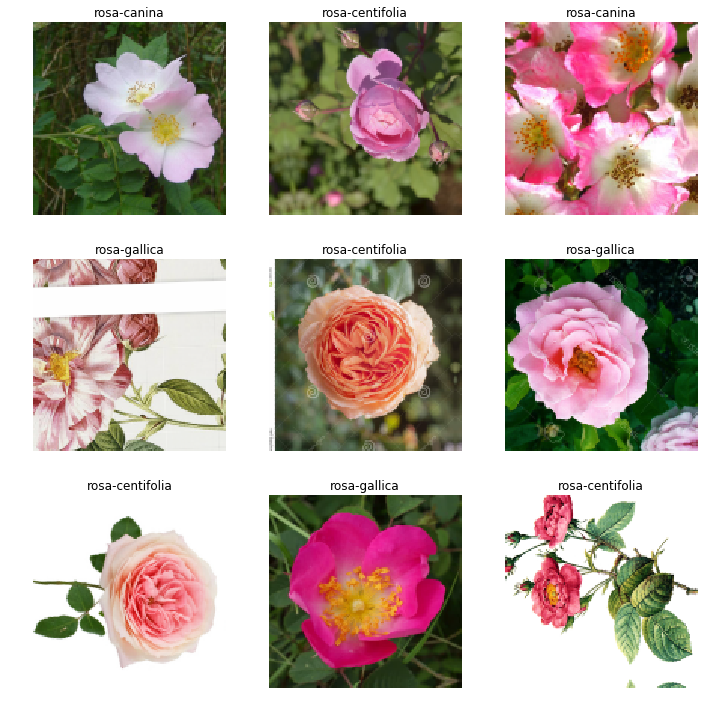

In [8]:
data.show_batch(rows=3, figsize=(10,10))

In [9]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s]


In [10]:
#learn.lr_find()

In [11]:
#learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.894678,1.357170,0.602740,00:18
1,1.540777,0.883841,0.315068,00:17
2,1.292994,0.814492,0.287671,00:18
3,1.094629,0.754295,0.273973,00:17
4,0.974196,0.750957,0.287671,00:18


In [13]:
#learn.unfreeze(); learn.lr_find(); learn.recorder.plot()

In [14]:
learn.fit_one_cycle(10, 5* 1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.803139,0.761332,0.315068,00:19
1,0.890943,0.760273,0.301370,00:18
2,0.776024,0.757919,0.301370,00:17
3,0.736001,0.761986,0.301370,00:17
4,0.727425,0.753556,0.273973,00:17
5,0.726387,0.717899,0.273973,00:17
6,0.700441,0.738574,0.260274,00:17
7,0.665814,0.695926,0.260274,00:17
8,0.629387,0.671177,0.246575,00:17
9,0.674157,0.705168,0.246575,00:18


In [15]:
#learn.unfreeze()
#learn.lr_find()
#learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10, 5* 1e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.574203,0.706931,0.260274,00:18
1,0.589917,0.699407,0.232877,00:17
2,0.606098,0.664274,0.232877,00:18
3,0.633658,0.679107,0.246575,00:17
4,0.675518,0.701237,0.260274,00:17
5,0.717690,0.739875,0.260274,00:18
6,0.679884,0.716986,0.260274,00:17
7,0.664811,0.719603,0.260274,00:18
8,0.663641,0.714256,0.260274,00:18
9,0.636478,0.715961,0.232877,00:18


## Time to train (approximate, excluding lr find time)

In [17]:
time.time() - start_time

463.4623239040375

## Inference

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

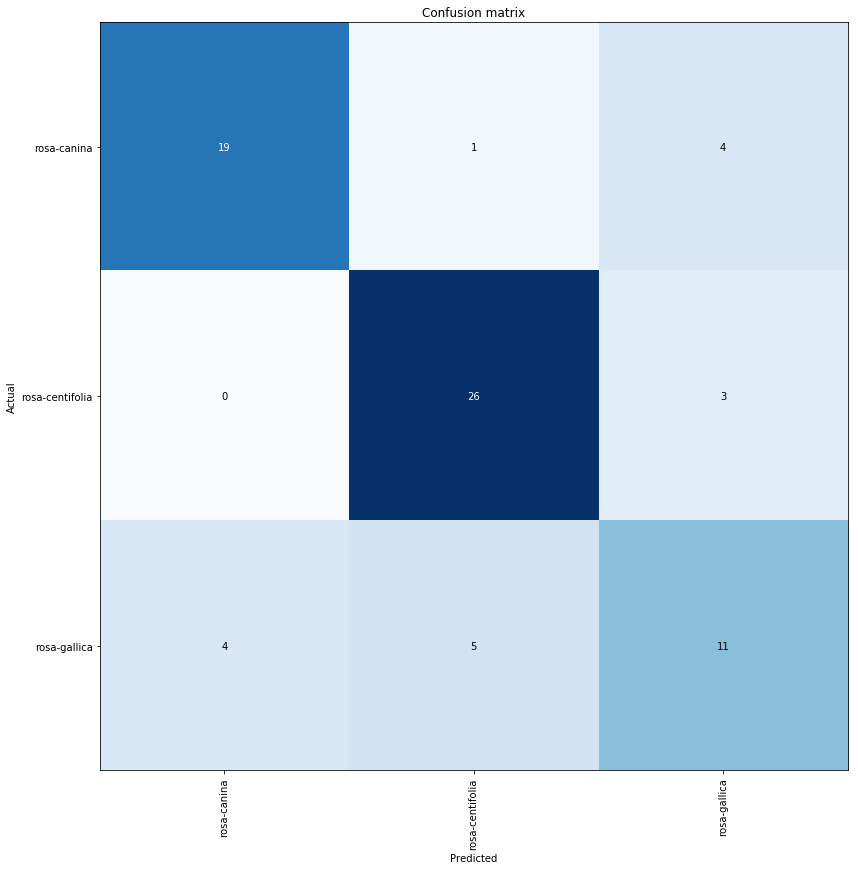

In [19]:
interp.plot_confusion_matrix(figsize=(12,12))

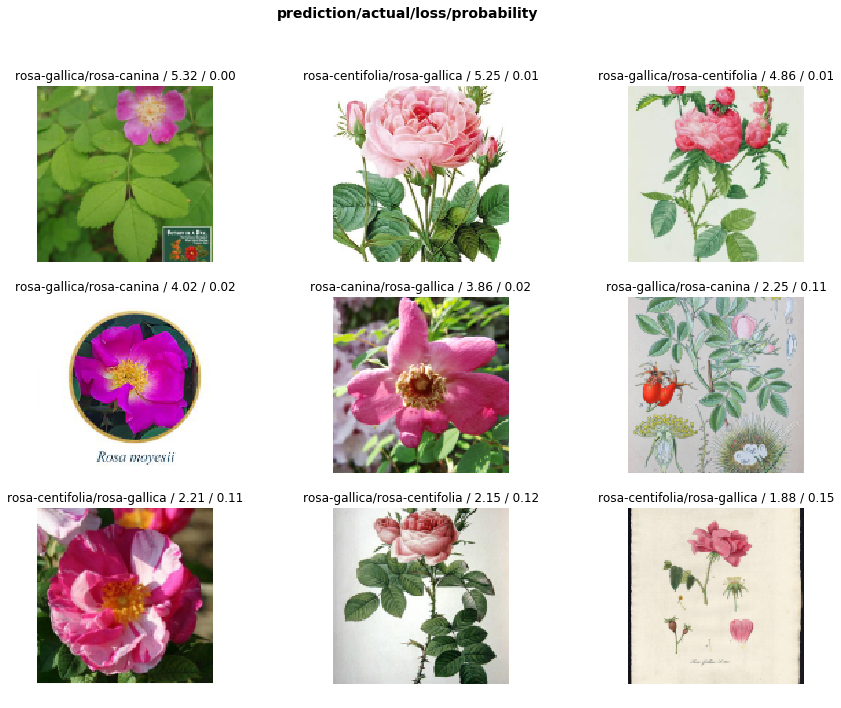

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

In [21]:
interp.most_confused(min_val = 1)

[('rosa-gallica', 'rosa-centifolia', 5),
 ('rosa-canina', 'rosa-gallica', 4),
 ('rosa-gallica', 'rosa-canina', 4),
 ('rosa-centifolia', 'rosa-gallica', 3),
 ('rosa-canina', 'rosa-centifolia', 1)]

In [22]:
import os
import io
import tarfile
import PIL
import boto3
from fastai.vision import *

IMAGE_SIZE = 160 # Should match with the size specified while building the model.
learn.save("roses-model")
source_file = learn.model_dir + "roses-model" + ".pth"
dest_file = "roses-model" + ".pth"
shutil.copy2(source_file, dest_file)
save_texts('classes.txt', data.classes)
trace_input = torch.ones(1,3,IMAGE_SIZE,IMAGE_SIZE).cuda()
jit_model = torch.jit.trace(learn.model.float(), trace_input)
model_file='roses_resnet50_jit.pth'
output_path = str({model_file})
#torch.jit.save(jit_model, output_path)
torch.jit.save(jit_model, 'roses_resnet50_jit.pth')
tar_file='roses.tar.gz'
classes_file='classes.txt'

print(os.listdir("."))
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(model_file, arcname=model_file)
    f.add(classes_file, arcname=classes_file)

['__output__.json', '__notebook__.ipynb', 'classes.txt', 'roses-model.pth', 'roses_resnet50_jit.pth']
